In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
from amftrack.util.plot import gridplot
plt.style.use('presentation.mplstyle')

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_analysis_folders = get_analysis_folders()
plates = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    # "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,use_saved=False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,use_saved=False)

In [ ]:
plates_in = all_analysis_folders['unique_id'].unique()

In [4]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 50,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {59 : 30,69 : 30}
timestep = {**timestep, **timestep2}

2023-03-16 17:45:35,361-[WARNING]- matplotlib.backends.backend_ps:296 -> The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


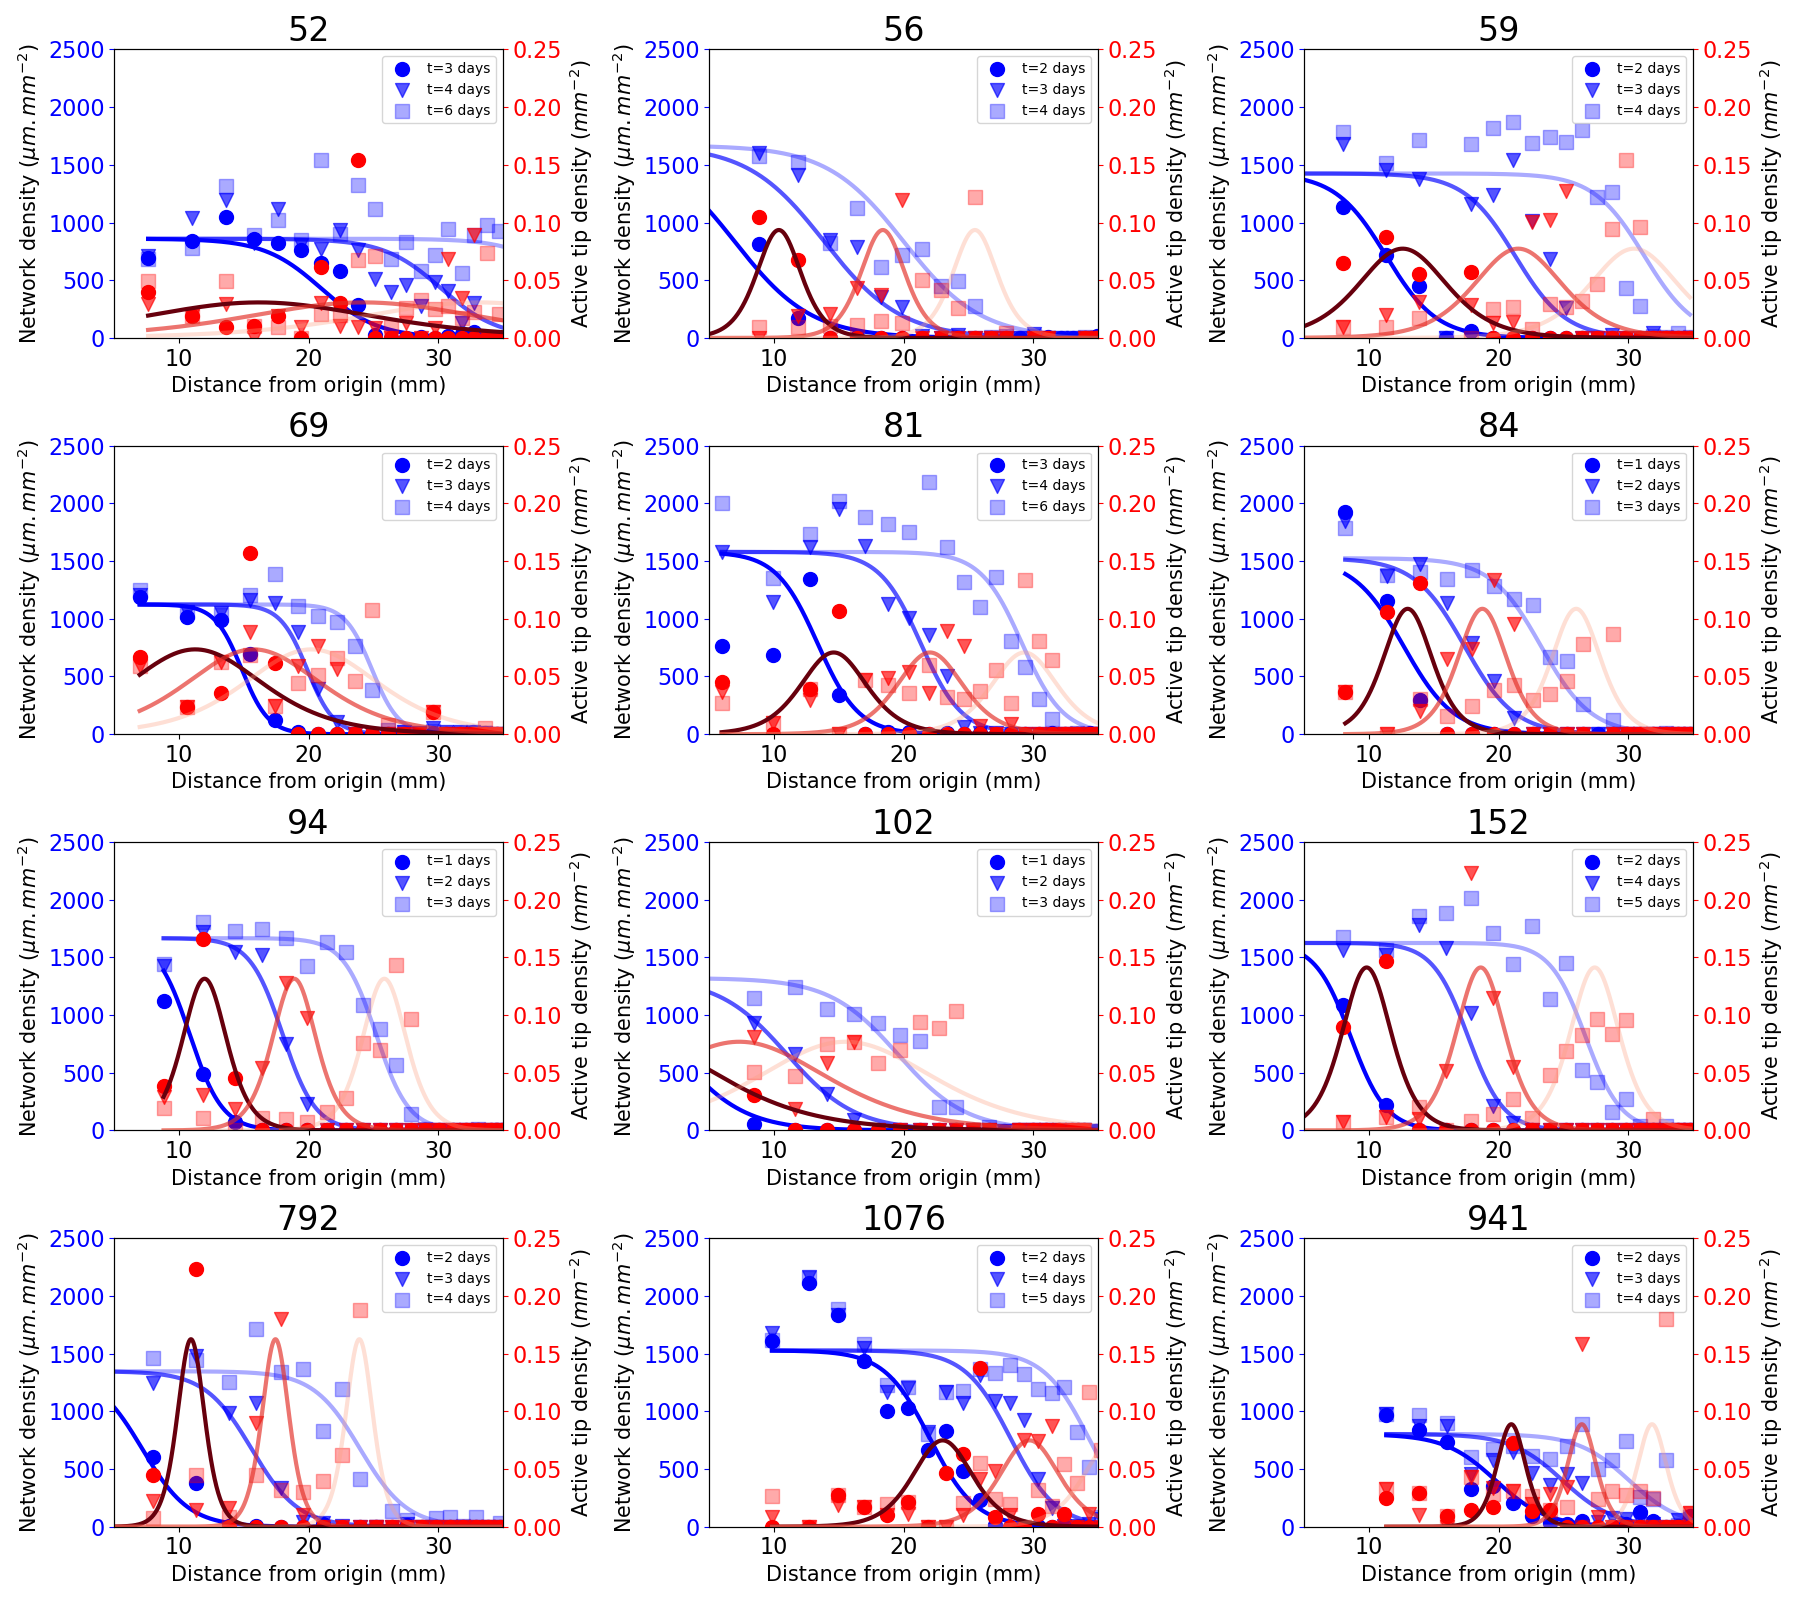

In [56]:
plates = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    # "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404"
]
max_indexes = {int(plate.split('_')[0]) : 20 for plate in plates}
ncols =3
fig,axs = gridplot(len(plates),ncols = ncols,subh = 4.0,subw = 6)
cmap1 = mpl.cm.get_cmap("summer")
cmap2 = mpl.cm.get_cmap("Reds")
for j,ax in enumerate(axs):
    plate = plates[j]
    plate = int(plate.split('_')[0])
    timesteps= range(0,timestep[plate]) 

    popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
    table = time_plate_info.loc[time_plate_info["Plate"]==plate]
    table = table.replace(np.nan,-1)
    ts = list(table['timestep'])
    table = table.set_index('timestep')
    ts = list(table.index)
    ts.sort()
    dic = {}
    ax.axis([5,35,0,2500])
    ax.set_xlabel('Distance from origin (mm)')
    ax.set_ylabel('Network density ($\mu m.mm^{-2}$)') 
    ax2=ax.twinx()
    ax2.set_ylim((0,0.25))
    ax2.set_ylabel('Active tip density ($mm^{-2}$)')
    ax.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='red')
    timesteps = range(0,timestep[plate],timestep[plate]//4) 
    timesteps = list(timesteps)[-3:]
    lines = []
    markers = ['o','v','s']
    for i,t in enumerate(timesteps):
    #     ax.set_yscale("log")

        maxL = np.sqrt(1900)
        X = np.linspace(0,maxL,100)
        incr = 100
        def density(x):
            area = x**2
            index = int(area//incr)
            column = f"ring_density_incr-100_index-{index}"
            return(float(table[column][t]))
        xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
        yvalues = [density(x) for x in xvalues]
        xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
        dic[t] = {}
        dic[t]['distance_origin'] = xvalues
        dic[t]['ring_density'] = yvalues
        xvalues = np.array(xvalues)
        yvalues = np.array(yvalues) 
        X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
        Y = yvalues
        line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
        lines.append(line)
        ax.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color="blue",label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days',
               alpha = (len(timesteps)-i)/len(timesteps),linewidth=1,marker = markers[i])

        xs = np.linspace(np.min(X),np.max(X),1000)
        ts = [table['time_since_begin_h'][t] for x in xs]
        xt = np.array((xs,ts))
        line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
        lines.append(line)
        ax.plot(xs,wave(xt,*popt_f),alpha = (len(timesteps)-i)/len(timesteps),color='blue')
        def density(x):
            area = x**2
            index = int(area//incr)
            column = f"ring_active_tips_density_incr-100_index-{index}"
            return(float(table[column][t]))
        xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
        yvalues = [density(x) for x in xvalues]
        xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
        dic[t]['tip_density'] = yvalues
        xvalues = np.array(xvalues)
        yvalues = np.array(yvalues) 
        X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
        Y = yvalues
        ax2.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = markers[i],color="red",
               alpha = (len(timesteps)-i)/len(timesteps))

        line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1))}
        lines.append(line)
        xs = np.linspace(np.min(X),np.max(X),1000)
        ts = [table['time_since_begin_h'][t] for x in xs]
        xt = np.array((xs,ts))
        ax2.plot(xs,dwave(xt,*popt_f2),alpha = (len(timesteps)-i)/len(timesteps),color=cmap2((len(timesteps)-i)/len(timesteps)))
        xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    #     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]*10, facecolor=cmap2((len(timesteps)-i)/len(timesteps)), edgecolor="black") for j,x in enumerate(xs)]

    #     for ellipse in ellipses:
    #         ax2.add_artist(ellipse)
        line = {"type" : "fit tip density","x" : xs,"y" : dwave(xt,*popt_f2),"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1)) }
        lines.append(line)
        right = 0.90
        top = 0.90
        fontsize = 10
        ax.legend()
        ax.set_title(plate)
        # ax2.legend()

plt.tight_layout()
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\FigureS1"
plt.savefig(os.path.join(path_figure,'FigureS1A.svg'))
plt.savefig(os.path.join(path_figure,'FigureS1A.eps'))

plt.savefig(f'Figure/FigureS1A.svg')

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


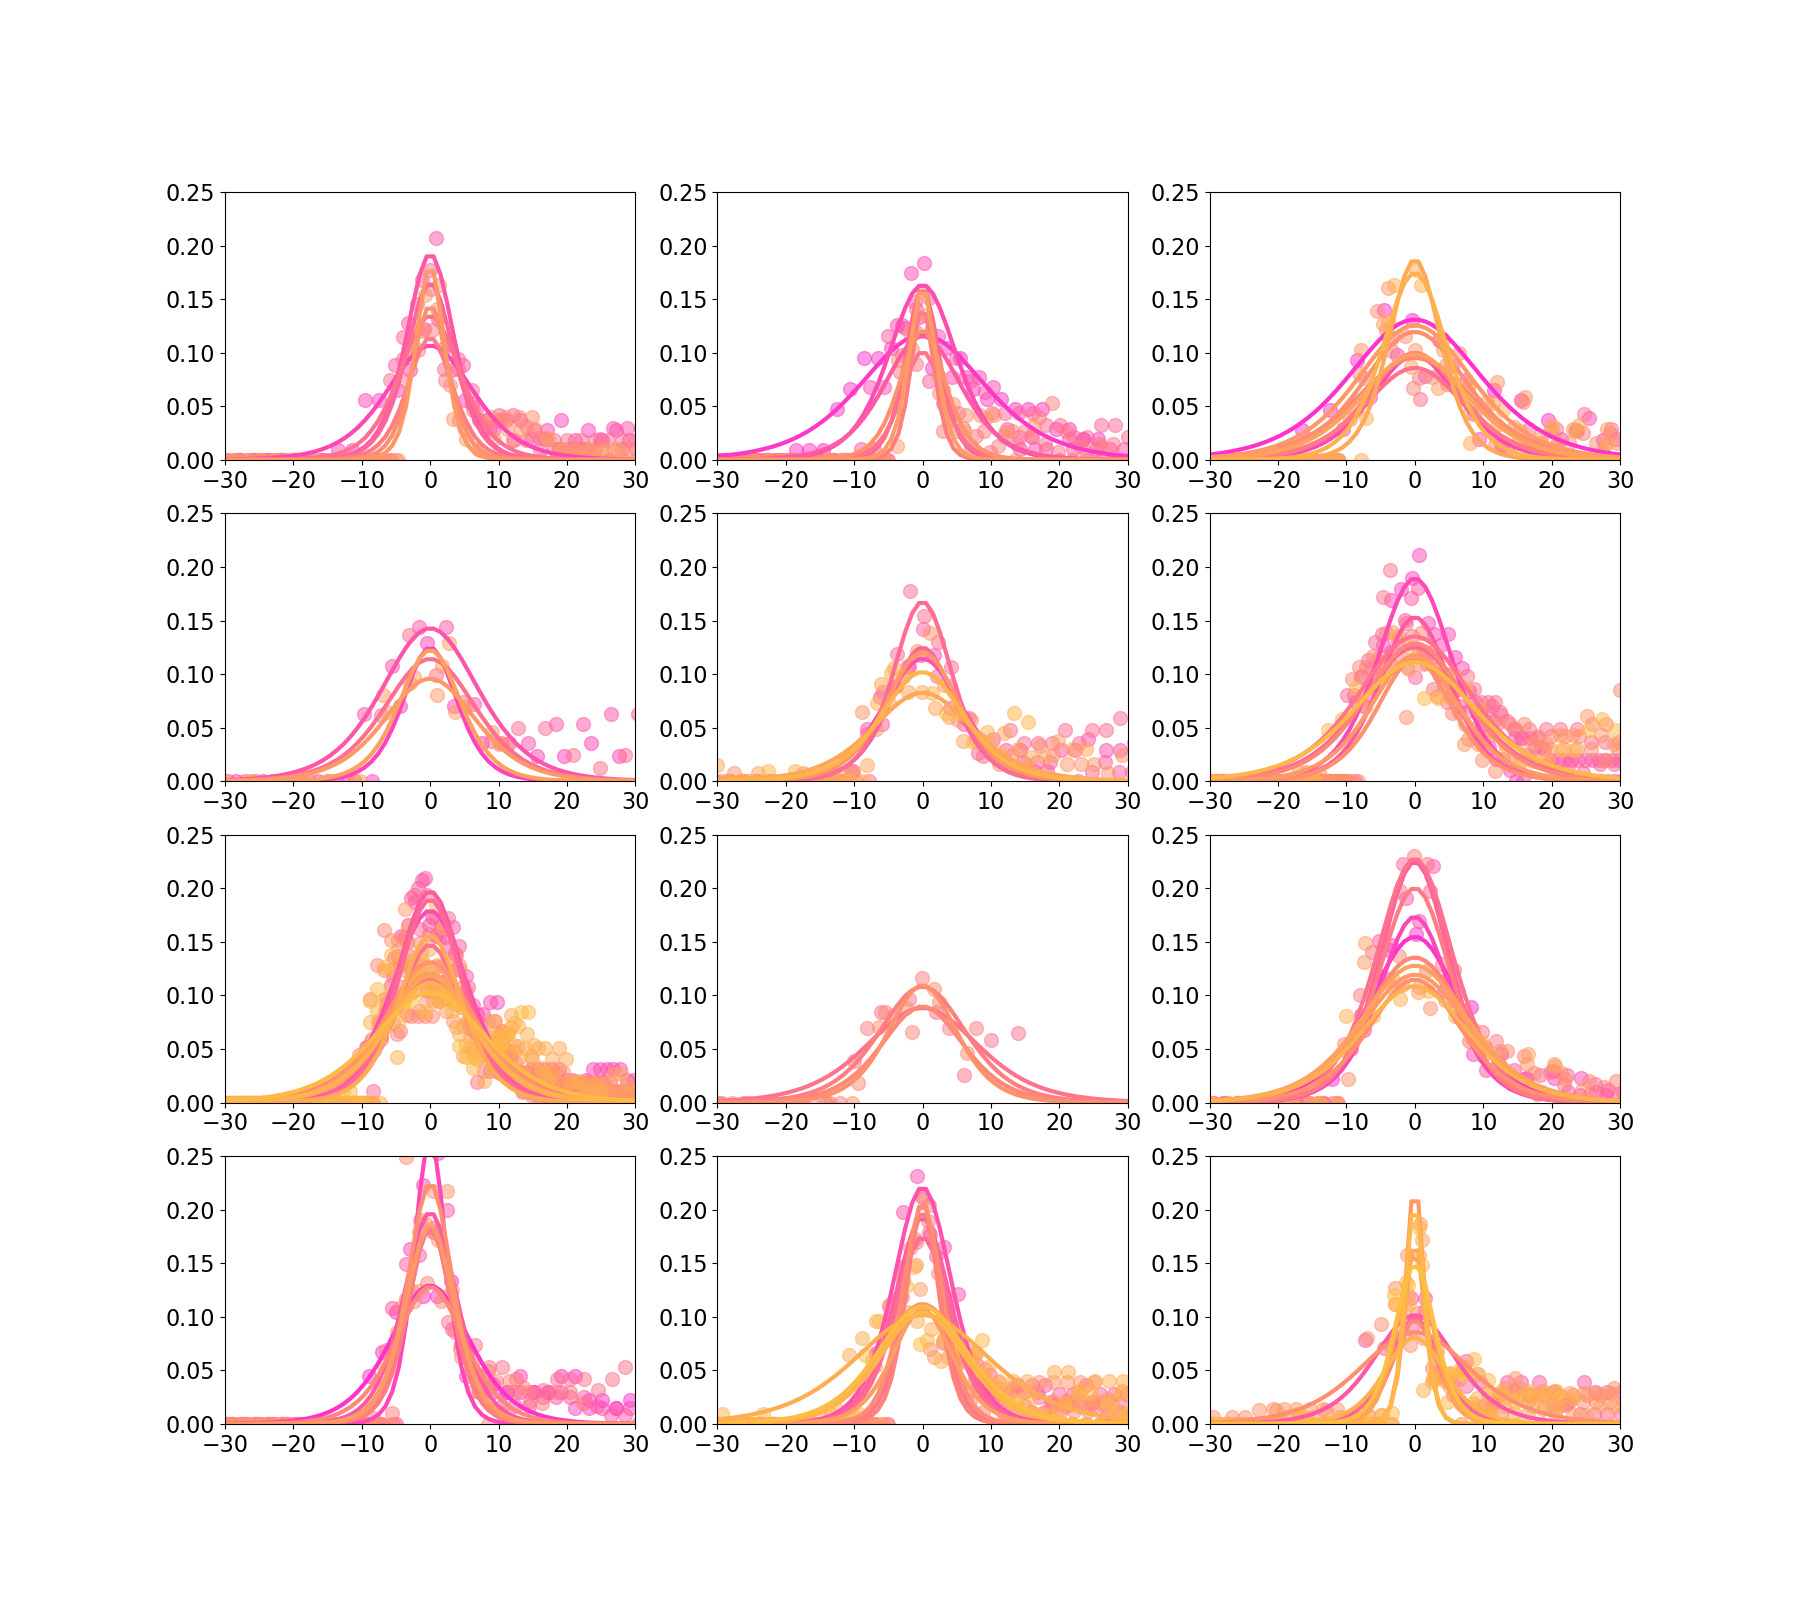

In [9]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
maxi = 13
max_area=50
Csstips = {}
ncols =3
lambsstips = {}
fig,axs = gridplot(len(plates),ncols = ncols,subh = 4.0,subw = 6)
dss = {}
for j,ax in enumerate(axs):
    plate = plates[j]
    plate = int(plate.split('_')[0])
    timesteps= range(0,timestep[plate]) 
    timestep_max =timestep[plate]
    table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
    table = table.loc[table["timestep"] <= timestep_max]
    table = table.set_index("timestep")
    ts = []
    ys = []
    ys2 = []
    Cs = []
    Cserror = []
    t0serror = []
    lambs = []
    indexes = []
    t0s = []
    ds = []
    Cstips = []
    lambstip = []
    
    for index in range(1, maxi):
        column = f"ring_density_incr-100_index-{index}"
        column2 = f"ring_active_tips_density_incr-100_index-{index}"

        start = np.min(
            table.loc[table[column] >= 400]["time_since_begin"]
        )
        table[f"time_since_begin_{index}"] = (
            table["time_since_begin"] - start
        )/pd.Timedelta(hours = 1)

        area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
        selection_fit = table
        xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]

        selection_fit = table
        try:
            popt0, pcov = curve_fit(
                S,
                xis,
                yis,
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[1, 1, 0],
            )
            lamb, C, t0 = list(popt0)
            table[f"time_since_begin_{index}"] = table[f"time_since_begin_{index}"] - t0

    #         ax.scatter(
    #             table[f"time_since_begin_{index}"],
    #             table[column],
    #             alpha=0.5,
    #             color=cmap2(area / max_area),
    #         )

            xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
            data = np.array((xis,yis))
            def statistic(x,y):
                try:
                    popt0, pcov = curve_fit(
                    S,
                    x,
                    y,
                    bounds=([0, 0, -np.inf], 3 * [np.inf]),
                    p0=[1, 1, 0],
                )
                    return(popt0[2])
                except:
                    return(C)
            xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
            data = np.array((xis,yis))
            t0s.append(t0+start/pd.Timedelta(hours=1))

            Cs.append(C)
            lambs.append(lamb)
            indexes.append(index)
            x = np.linspace(-50, 50, 100)
        # ax.plot(
        #     x,
        #     S(x + t0, lamb, C, t0),
        #     color=cmap2(area / max_area),
        #     label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
        # )
            popt1, _ = curve_fit(
                dS,
                selection_fit[f"time_since_begin_{index}"],
                selection_fit[column2],
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[0.2, 0.5, 0],
            )

            lamb, C, t1 = list(popt1)
            if lamb>0.15:
                Cstips.append(C)
                lambstip.append(lamb)
                ds.append(int(area / np.sqrt((np.pi / 2))))
                
                ax.scatter(
                    table[f"time_since_begin_{index}"]-t1,
                    table[column2],
                    alpha=0.5,
                    color=cmap1(area / max_area),
                )
                ax.plot(
                    x,
                    dS(x +t1, lamb, C, t1),
                    color=cmap1(area / max_area),
                    label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
                )
                ts += table[f"time_since_begin_{index}"].to_list()
                ys += table[column].to_list()
                ys2 += table[column2].astype(float).to_list()
        except:
            pass
    df = pd.DataFrame(
        (np.array((ts, ys, ys2))).transpose(), columns=("ts", "ys", "ys2")
    )
    factor = 4
    df["ts_round"] = (df["ts"] / factor).astype(int) * factor
    meancurve = df.groupby("ts_round")["ys"].mean()
    # ax.plot(meancurve.index, meancurve, label="mean", color="black")
    meancurve2 = df.groupby("ts_round")["ys2"].mean()
    # ax2.plot(meancurve.index-t1, meancurve2, label=plate, color = 'black')
    ax.set_xlim((-30, 30))
    ax.set_ylim((0, 0.25))
    # ax.set_ylim((0, 2500))

    # ax.set_ylabel("Network density ($\mu m.mm^{-2}$)")
    # ax2.set_xlabel("Shifted time ($h$)")
    # ax2.set_ylabel("Active tips density ($mm^{-2}$)")
    # ax.tick_params(axis="y", colors="blue")
    # ax2.tick_params(axis="y", colors="red")
    Csstips[plate] = Cstips
    lambsstips[plate] = lambstip
    dss[plate] = ds

Text(0, 0.5, 'peak value')

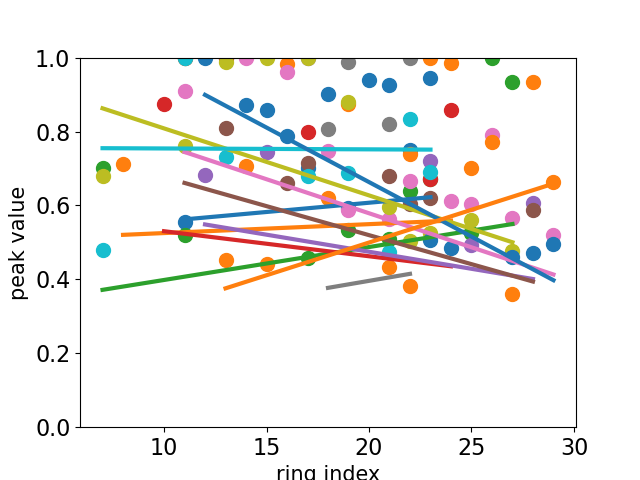

In [10]:
fig, ax = plt.subplots()

for plate in plates:
    plate = int(plate.split('_')[0])
    Cstips = np.array(Csstips[plate])
    ds = dss[plate]
    ax.scatter(ds,Cstips/np.max(Cstips))
    x = np.array(ds)
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(Cstips,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(x,x*a+b)
ax.set_ylim(0,1)
# fig, ax = plt.subplots()

# for plate in plates[6:]:
#     plate = int(plate.split('_')[0])
#     Cstips = Csstips[plate]
#     ax.plot(range(len(Cstips)),Cstips,alpha = 0.3)
#     # x = np.array(range(len(Cstips)))
#     # X = sm.add_constant(x, prepend=False)
#     # model = sm.OLS(Cstips,X)
#     # res = model.fit()
#     # a,b = res.params[0],res.params[1]
#     # ax.plot(x,x*a+b)
# ax.set_ylim(0,1)
ax.set_xlabel("ring index")
ax.set_ylabel("peak value")

In [ ]:
def statistic(plates):
    Cstot = []
    for plate in plates:
        plate = int(plate.split('_')[0])
        Cstips = np.array(Csstips[plate])/np.max(Cstips)
    Cstot = 
        

Text(0, 0.5, 'peak value')

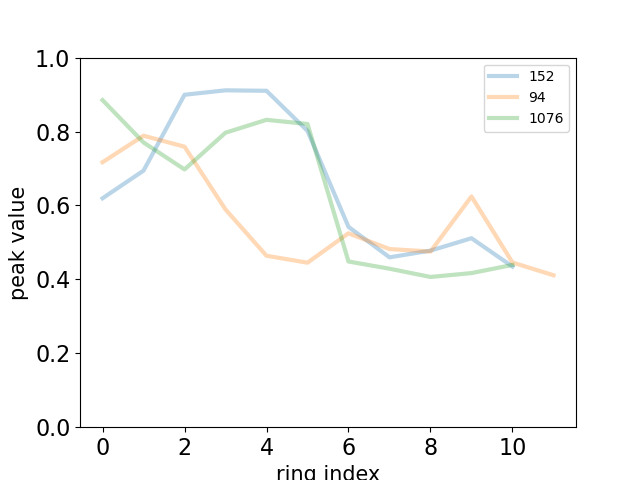

In [52]:
fig, ax = plt.subplots()

for plate in [152,94,1076]:
    Cstips = Csstips[plate]
    ax.plot(range(len(Cstips)),Cstips,alpha = 0.3,label=plate)
    # x = np.array(range(len(Cstips)))
    # X = sm.add_constant(x, prepend=False)
    # model = sm.OLS(Cstips,X)
    # res = model.fit()
    # a,b = res.params[0],res.params[1]
    # ax.plot(x,x*a+b)
ax.set_ylim(0,1)
ax.legend()
ax.set_xlabel("ring index")
ax.set_ylabel("peak value")

In [45]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

0         0.000000
1         3.650000
2         7.666667
3        11.650000
4        15.650000
           ...    
1781    308.500000
1782    312.500000
1783    316.500000
1784    320.516667
1785    324.516667
Name: time_since_begin, Length: 1786, dtype: float64

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:37: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  

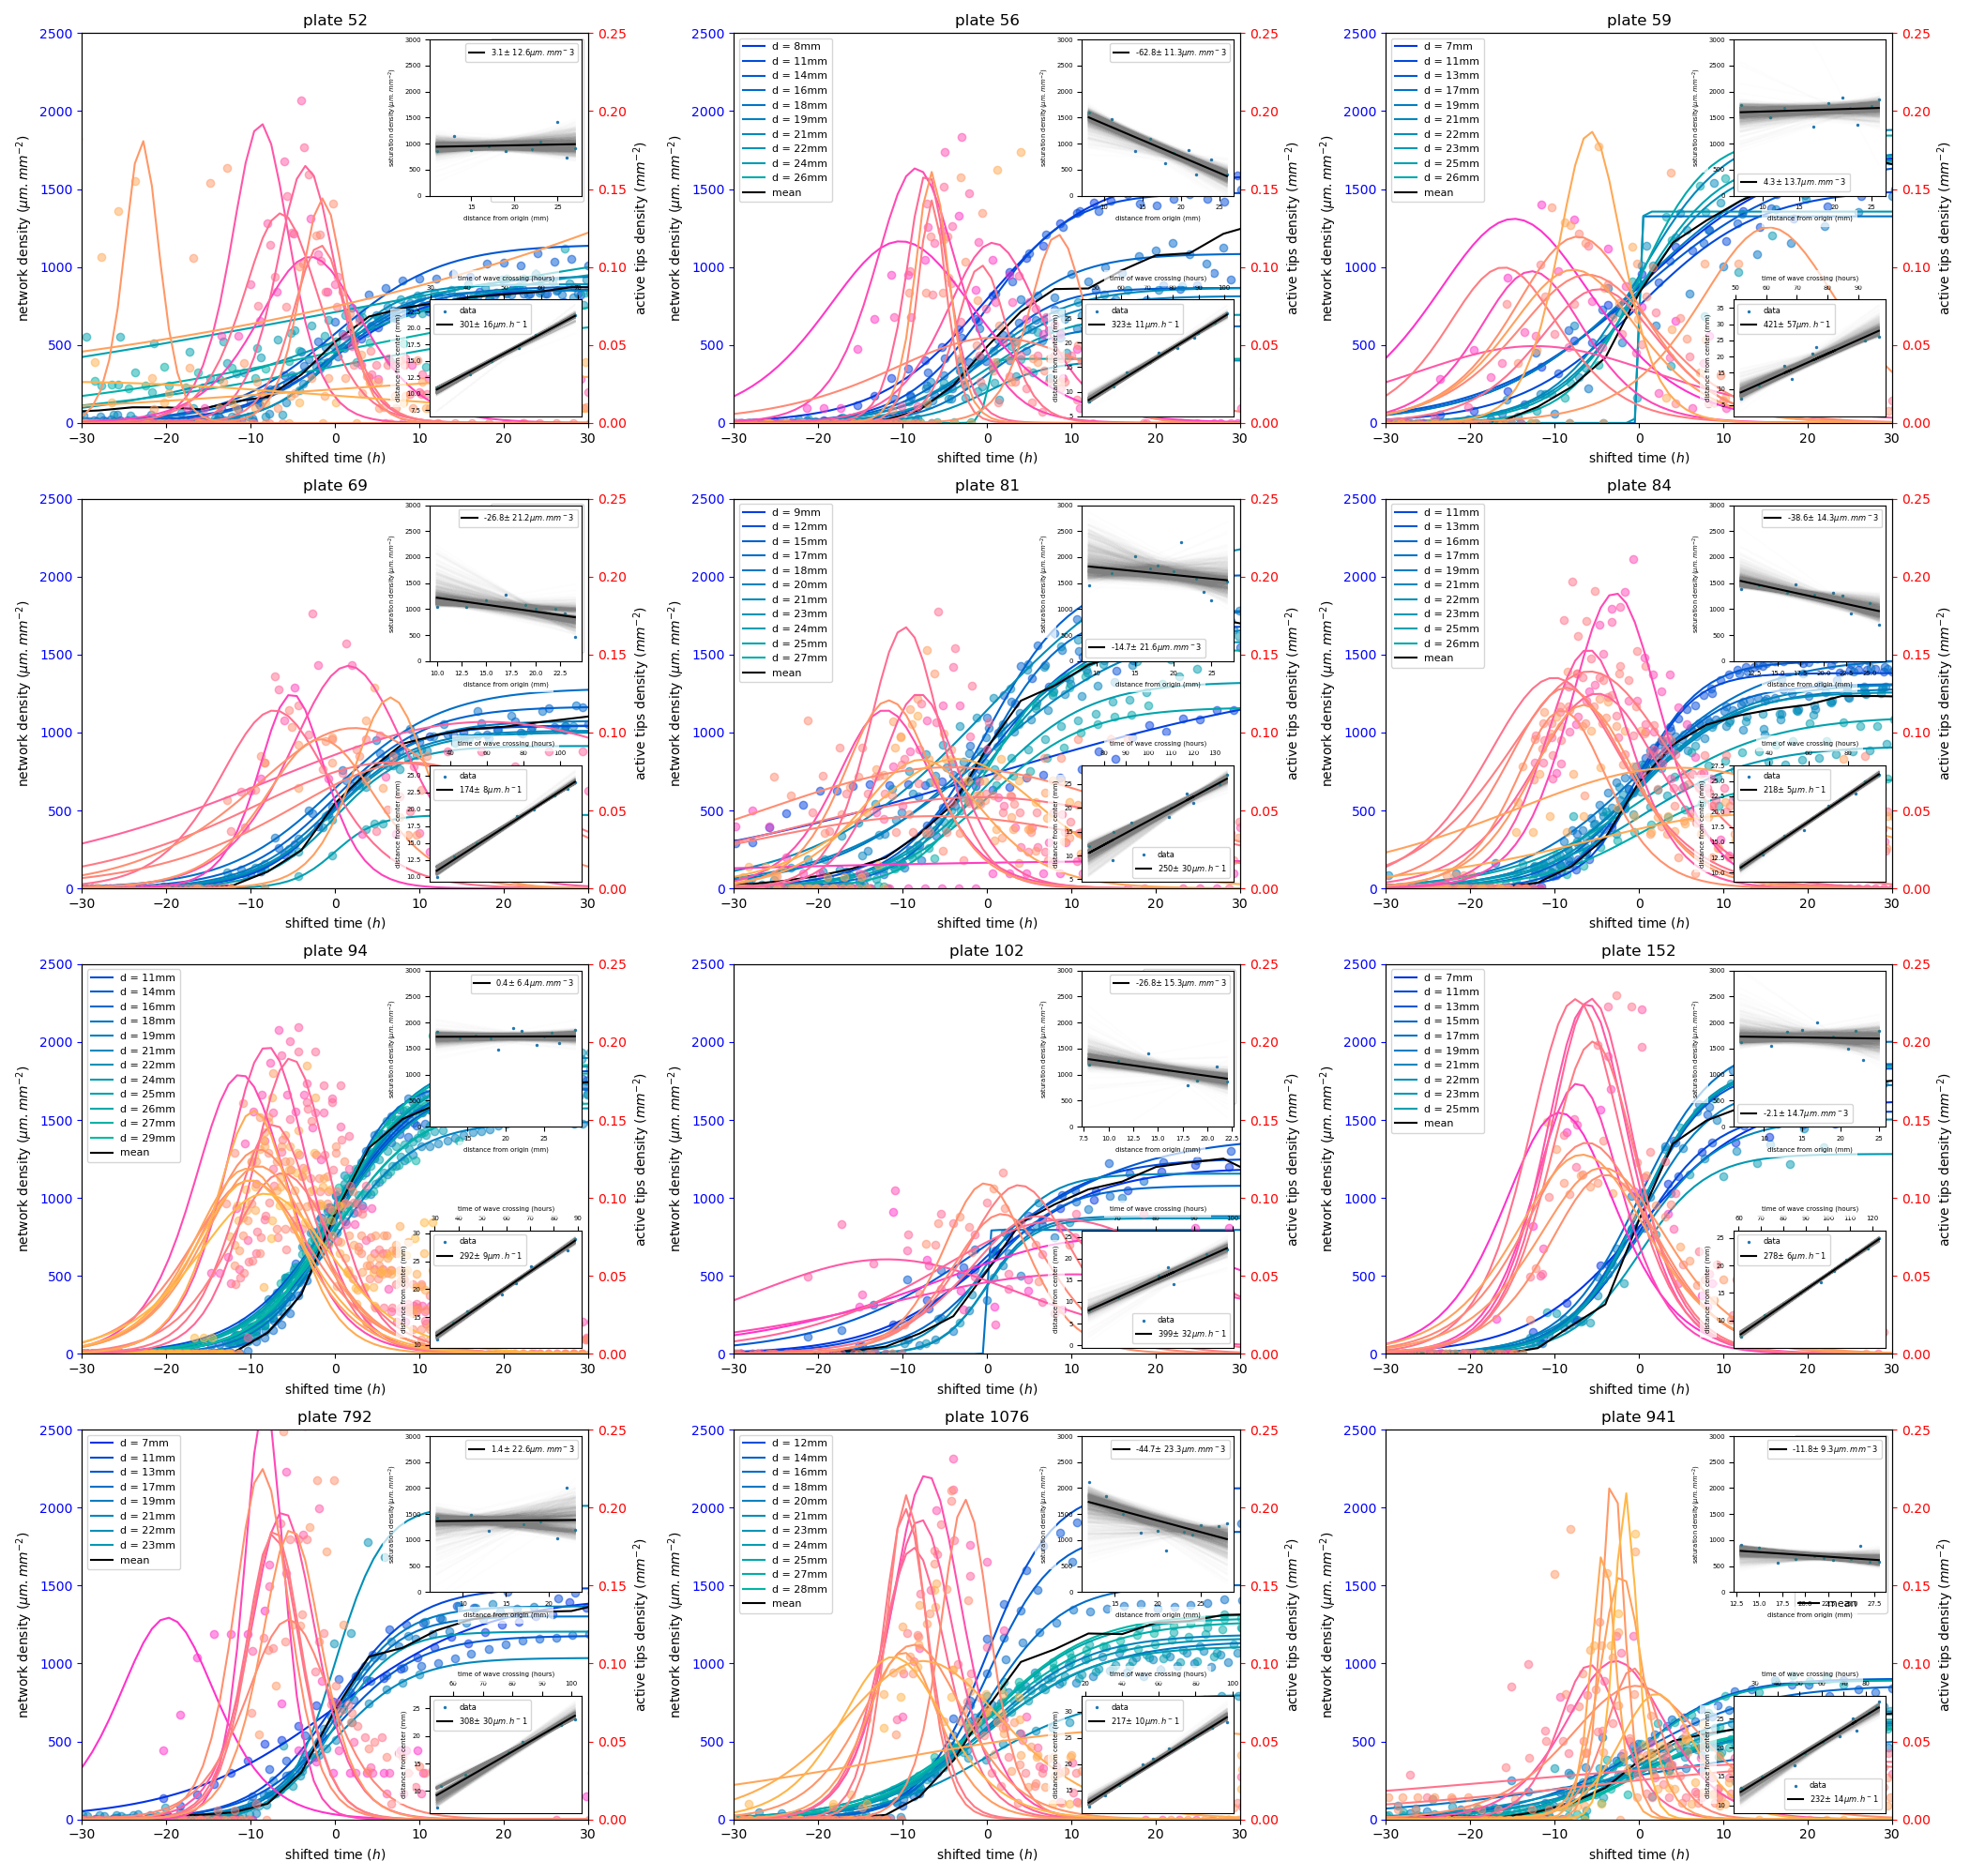

In [54]:
# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plates),ncols = ncols,subh = 5,subw = 7)

maxis = {int(plate.split('_')[0]) :12 for plate in plates}
maxis[94] = 13
maxis[152] = 11
maxis2 = {int(plate.split('_')[0]) :12 for plate in plates}
maxis2[52] = 6
maxis2[938] = 7
# maxis[938] = 8

bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")
time_plate_info_copy = time_plate_info.copy()
time_plate_info_copy['time_since_begin'] = time_plate_info_copy['time_since_begin']/pd.Timedelta(hours = 1)
ax_list = list(axs)
for j in range(len(plates)):
    plate = plates[j]
    plate = int(plate.split('_')[0])
    ax = ax_list[j]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info_copy,timestep[plate],ax,maxi =maxis[plate])
    meancurves[plate]=meancurve
    meancurves2[plate]=meancurve2
    Css[plate] = Cs
    lambss[plate] = lambs
    dss[plate] = ds
    t0ss[plate] = t0s
    axins2 = inset_axes(ax, width="30%", height="40%", loc=1)
    x0 = np.linspace(np.min(ds),np.max(ds),10)
    statistic = make_stat(x0,axins2)

    data = np.array((ds,Cs))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
    axins2.scatter(ds,Cs,s = 2)
    axins2.set_ylim(0,3000)
    axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
    axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
    axins2.tick_params(labelsize = 5)
    axins2.legend(fontsize = 6)
    t0s = t0ss[plate][:maxis2[plate]]
    ds = dss[plate][:maxis2[plate]]
    axins3 = inset_axes(ax, width="30%", height="30%", loc=4,borderpad = 0.5)
    x0 = np.linspace(np.min(t0s),np.max(t0s),10)
    statistic = make_stat(x0,axins3)
    data = np.array((t0s,ds))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    axins3.scatter(t0s,ds,label = "data",s=2)
    X = sm.add_constant(t0s, prepend=False)
    model = sm.OLS(ds,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    axins3.plot(t0s,np.array(t0s)*a+b,label = f"{int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$",color="black")
    axins3.tick_params(labelsize = 5)
    axins3.xaxis.tick_top()
    axins3.xaxis.set_label_position('top') 
    axins3.legend(fontsize = 6 )
    axins3.set_ylabel('distance from center (mm)',size = 5,bbox=bbox)
    axins3.set_xlabel('time of wave crossing (hours)',size = 5,bbox=bbox)
    # break
# plt.legend()

plt.savefig(f'Figure/FigureS1B.svg')    

In [10]:
plates = plate_select
analysis_folders = analysis_folders.loc[analysis_folders['Plate'].isin(plates)]
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)

C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226_200_Version1\time_hypha_info\hyph_info_79.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226_200_Version1\time_hypha_info\hyph_info_80.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226_200_Version1\time_hypha_info\hyph_info_81.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226_200_Version1\time_hypha_info\hyph_info_82.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226_200_Version1\time_hypha_info\hyph_info_83.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226_200_Version1\time_hypha_info\hyph_info_84.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226_200_Version1\time_hypha_info\hyph_info_85.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\102_20201226\Analysis_102_20201226

MemoryError: Unable to allocate 1.30 MiB for an array with shape (1, 170398) and data type object

In [ ]:
plate

In [ ]:
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)
ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

    data,dy,select_movements = get_average_time_data(plate,time_hypha_info,2)
    hyphae_hull = get_hyphae_hull(plate,analysis_folders)
    if len(hyphae_hull)>0:
        label = 'hull pusher'
        for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
            select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
            select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
            select = select.loc[select['speed'].between(150,350)]
            if len(select)>0:
                time = select['time_since_begin_h'].iloc[0]
                if time/pd.Timedelta(hours = 1)<=100:
                    ax.scatter(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),color='black')
                    ax.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
                    label = None
                    hull_speeds.append(np.mean(select["speed"]))
                    hull_time.append(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1))

                select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
                # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        # ax.plot(data.index/pd.Timedelta(hours = 1),data)
        ax.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
        ax.set_xlim(0,150)
        ax.set_ylim(150,350)

        ax.legend()
        # ax.set_title(f'{plate}')
        ax.set_xlabel('time since begin (h)')
        ax.set_ylabel('speed ($\mu m.h^{-1}$)')
            # break
        ax.set_xlim(0,100)
        plt.tight_layout()
        ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
                color="black",
                label= f'mean hull pusher speed {int(np.nanmean(hull_speeds))}$\pm${int(2*np.nanstd(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
        ax.legend()
    # break
plt.savefig(f'Figure/FigureS1C.svg')    

In [ ]:
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 4.0,subw = 6)

maxis = {plate :12 for plate in plate_select}
maxis[52] = 6
maxis[938] = 7


ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    t0s = t0ss[plate][:maxis[plate]]
    ds = dss[plate][:maxis[plate]]
    ax.scatter(t0s,ds,label = "data")
    def statistic(t0s,ds):
        X = sm.add_constant(t0s, prepend=False)
        model = sm.OLS(ds,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(t0s,np.array(t0s)*a+b,color = 'grey', alpha = 0.01)

        return(a)
    data = np.array((t0s,ds))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    X = sm.add_constant(t0s, prepend=False)
    model = sm.OLS(ds,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(t0s,np.array(t0s)*a+b,label = f"linear fit : speed = {int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$")
    ax.legend()
    ax.set_ylabel('distance from center (mm)')
    ax.set_xlabel('time of wave crossing (hours)')
    ax.set_title(f'Plate {plate}')
    plt.tight_layout()
    plt.savefig(f'Figure/FigureS1C.svg')


In [ ]:
fig, ax = plt.subplots()
def statistic(ds,Cs):
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    color = plt.gca().lines[-1].get_color()
    ax.plot(ds,np.array(ds)*a+b,color = color, alpha = 0.01)
    return(a)

tot_ds = []
tot_Cs=[]

for plate in plate_select:
    Cs = Css[plate]
    ds = dss[plate]
    tot_ds+=ds
    tot_Cs+=Cs
    ax.scatter(ds,Cs,alpha = 0.2)
    
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(ds,np.array(ds)*a+b,label=plate)
    data = np.array((ds,Cs))
    
#     n_resamples=1000
#     std = scipy.stats.bootstrap(data,statistic,
#                                 vectorized = False,
#                                 method="basic",
#                                 n_resamples = n_resamples,
#                                 paired= True).standard_error
# X = sm.add_constant(tot_ds, prepend=False)
# model = sm.OLS(tot_Cs,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# ax.plot(tot_ds,np.array(tot_ds)*a+b,color = 'black')
df = pd.DataFrame((tot_ds,tot_Cs)).transpose()
df.columns = ('distance','saturation density')
data = np.array((tot_ds,tot_Cs))
# n_resamples=10000
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error

# data = df.groupby('distance').mean()
# ax.plot(data.index,data,label="average",color='black',linewidth=10,alpha = 0.5)    
ax.legend()
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density($\mu m.mm^{-1}$)')
plt.tight_layout()
plt.savefig(f'Figure/FigureS1Bsubset.svg')    
# ax.set_ylim(0,2500)


In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
for plate in plate_select:
# for plate in [938]:
    t0s = t0ss[plate][:maxis[plate]]
    ds = dss[plate][:maxis[plate]]
    X = sm.add_constant(t0s, prepend=False)
    model = sm.OLS(ds,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    x = np.array(t0s)+b/a
    ax.plot(x,np.array(t0s)*a+b,label = f"{plate} : speed = {int(1000*a)}$\mu m.h^{-1}$")
    ax.scatter(x,ds)
    
ax.legend()
ax.set_ylabel('distance from center (mm)')
ax.set_xlabel('time of wave crossing (hours)')
plt.tight_layout()
plt.savefig(f'Figure/FigureS1C2.svg')    

In [ ]:
strains = ["'A5'","'A5sp3'"]
plates = [plate for plate in folders['unique_id'].unique() if folders.loc[folders['unique_id']==plate].iloc[0]['strain'] in strains]
treatments = ["'001P100N100C'","'001P100N'"]
plates = [plate for plate in plates if folders.loc[folders['unique_id']==plate].iloc[0]['medium'] in treatments]
plates.remove(87720220419)
plates.remove(40320221005)
plates.remove(90720220321)

In [ ]:
# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plates),ncols = ncols,subh = 4.0,subw = 8)
maxis = {plate :12 for plate in plates}
for i in range(len(plates)):
    plate=plates[i]
    ax = axs[i]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[int(str(plate)[:-8])],ax,maxi =maxis[plate],unique_id = True)
    meancurves[plate]=meancurve
    meancurves2[plate]=meancurve2
    Css[plate] = Cs
    lambss[plate] = lambs
    dss[plate] = ds
    t0ss[plate] = t0s

In [ ]:
# plt.close('all')
fig, ax = plt.subplots()

ax2 = ax.twinx()

for plate in plates:
    meancurve = meancurves[plate]
    meancurve2 = meancurves2[plate]
    ax.plot(meancurve.index,meancurve,label=int(str(plate)[:-8]))
    ax2.plot(meancurve.index,meancurve2,label=int(str(plate)[:-8]),linestyle="dashed")
ax.set_xlim((-30,30))
ax2.set_ylim((0,0.2))

ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
# plates = [52,152,94,102,83,84,792,76]

for plate in plates:
    if int(str(plate)[:-8]) not in [91,89,56]:
        Cs = Css[plate]
        ds = dss[plate]
        tot_ds+=ds
        tot_Cs+=Cs
        ax.plot(ds,Cs,label = int(str(plate)[:-8]))
df = pd.DataFrame((tot_ds,tot_Cs)).transpose()
df.columns = ('distance','saturation density')
data = df.groupby('distance').mean()
ax.plot(data.index,data,label="average",color='black',linewidth=10,alpha = 0.5)    
ax.legend()
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density ($\mu m.mm^{-1}$)')
plt.tight_layout()